In [180]:
from mpl_toolkits.basemap import Basemap
import wradlib as wrl
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
import os
import netCDF4
import requests
from glob import glob
from datetime import datetime, timedelta
from geopy.geocoders import Nominatim
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
import calendar
import tarfile

In [18]:
#Download latest RX scan
response=requests.get("https://opendata.dwd.de/weather/radar/composit/rx/raa01-rx_10000-latest-dwd---bin")
with open('radolan_file', 'wb') as f:
    f.write(response.content)

rx_filename = "radolan_file"

rxdata, rxattrs = wrl.io.read_radolan_composite(rx_filename)
rxdata = np.ma.masked_equal(rxdata, -9999) / 2 - 32.5

# Get coordinates

radolan_grid_ll = wrl.georef.get_radolan_grid(900,900, wgs84=True)

lon_wgs0 = radolan_grid_ll[:,:,0]
lat_wgs0 = radolan_grid_ll[:,:,1]

datestring=rxattrs['datetime'].strftime("%Y-%m-%d %H:%M")

/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<

/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<

/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<

/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<

/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<

/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<

/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<

/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')
/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1299: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<

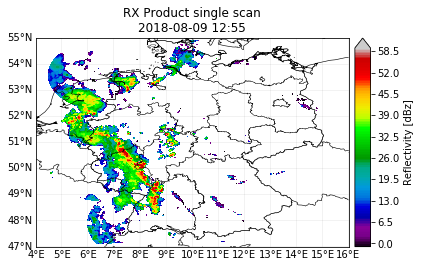

In [22]:
# plot RX product
# fig = pl.figure()
bmap = Basemap(projection='cyl', llcrnrlon=4, llcrnrlat=47, urcrnrlon=16, urcrnrlat=55,  resolution='i')

bmap.contourf(lon_wgs0,lat_wgs0,rxdata,np.arange(-1,60,0.5),cmap='nipy_spectral',extend="max")

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=0.6, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.6, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 1), linewidth=0.1, color='black', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 1), linewidth=0.1, color='black', labels=[True, False, False, True])
bmap.readshapefile('/Users/guidocioni/shapefiles/DEU_adm_shp/DEU_adm1','DEU_adm1',linewidth=0.3,color='black')

# Insert the legend
bmap.colorbar(location='right', label='Reflectivity [dBz]')

pl.title('RX Product single scan\n' + datestring)

# pl.grid(color='r')
pl.show()
# pl.savefig('radar'+rxattrs['datetime'].strftime("%Y%m%d%H%M")+'.png', dpi=150)

In [ ]:
#Optional
#Convert to netcdf
ncfile=netCDF4.Dataset('out.nc','w')

calendar = 'standard'
units = 'hours since 1970-01-01 00:00'
times=[rxattrs['datetime']]

ncfile.createDimension('nlon',900)
ncfile.createDimension('nlat',900)
ncfile.createDimension('time',None)

x = ncfile.createVariable('lon2d', 'd', ('nlon','nlat'))
y = ncfile.createVariable('lat2d', 'd', ('nlon','nlat'))

x.units = 'degrees_east'
y.units = 'degrees_north'

timevar = ncfile.createVariable(varname='time', dimensions=('time',) ,datatype='float64')
timevar.units = units
timevar[:] = netCDF4.date2num(times, units, calendar=calendar)
 
# transfer the coordinate variables:
x[:] = lon_wgs0
y[:] = lat_wgs0

# Create data variable in NetCDF.
data = ncfile.createVariable('rxdata', 'd', ('time','nlon','nlat'))
data.units='dbZ'
 
# transfer the data variables:
data[0,:,:] = rxdata

ncfile.close()

In [202]:
# Download data
folder="/Users/guidocioni/Downloads/"

response=requests.get("https://opendata.dwd.de/weather/radar/composit/fx/FX_LATEST.tar.bz2")
with open(folder+'FX_LATEST.tar.bz2', 'wb') as f:
    f.write(response.content)

tar = tarfile.open(folder+'FX_LATEST.tar.bz2', "r:bz2")
files=tar.getnames()
tar.extractall(folder)
tar.close()
os.remove(folder+'FX_LATEST.tar.bz2')

fnames=[folder + str(file) for file in files]

In [210]:
# Open the forecast data 
cities = ["Hamburg"]
geolocator = Nominatim()
box_average= 1

data=[]
datestring=[]

for fname in fnames:
    rxdata, rxattrs = wrl.io.read_radolan_composite(fname)
    data.append(np.ma.masked_equal(rxdata, -9999))
    minute = int(fname[fname.find("_MF002")-3:fname.find("_MF002")])
    datestring.append((rxattrs['datetime']+timedelta(minutes=minute)))
#     datestring.append((rxattrs['datetime']+timedelta(minutes=minute)).strftime("%Y-%m-%d %H:%M"))

# Compute local time
def utc_to_local(utc_dt):
    # get integer timestamp to avoid precision lost
    timestamp = calendar.timegm(utc_dt.timetuple())
    local_dt = datetime.fromtimestamp(timestamp)
    assert utc_dt.resolution >= timedelta(microseconds=1)
    return local_dt.replace(microsecond=utc_dt.microsecond)

for i in range(0,np.size(datestring)):
    datestring[i]=utc_to_local(datestring[i])

# Convert to a masked array
data=np.ma.array(data)
# Get coordinates
radolan_grid_ll = wrl.georef.get_radolan_grid(900,900, wgs84=True)
lon_wgs0 = radolan_grid_ll[:,:,0]
lat_wgs0 = radolan_grid_ll[:,:,1]

data_point={}
rain_point={}
for city in cities:
    loc = geolocator.geocode(city)
    lon_point=loc.longitude
    lat_point=loc.latitude
    dist=np.sqrt((lon_wgs0-lon_point)**2+(lat_wgs0-lat_point)**2)
    indx, indy=np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    data_point[city]=np.mean(data[:, indx-box_average:indx+box_average, indy-box_average:indy+box_average], axis=(1,2))
    rain_point[city]=wrl.zr.z_to_r(data_point[city], a=200., b=1.6)
    

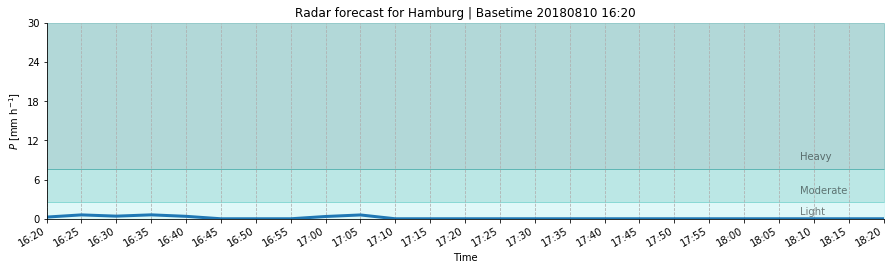

In [261]:
for city_to_plot in cities:
    fig = pl.figure(1, figsize=(15,4))
    pl.plot_date(datestring, rain_point['Hamburg'], '-',linewidth=3)
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().xaxis.grid(True, ls='dashed')
    pl.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    pl.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
    pl.gca().yaxis.set_major_locator(pl.MaxNLocator(5))
    pl.gca().set_title("Radar forecast for "+city_to_plot+" | Basetime "+datestring[0].strftime("%Y%m%d %H:%M"))
    pl.gca().set_ylabel("$P$ [mm h$^{-1}$]")
    pl.gca().set_xlabel("Time")
    pl.gca().set_ylim(bottom=0, top=30)
    pl.gca().set_xlim(left=datestring[0], right=datestring[-1])
    pl.gca().fill_between(datestring, y1=0, y2=2.5, alpha=0.4, color="paleturquoise")
    pl.gca().fill_between(datestring, y1=2.5, y2=7.6, alpha=0.3, color="lightseagreen")
    pl.gca().fill_between(datestring, y1=7.6, y2=30., alpha=0.3, color="teal")
    pl.gca().annotate("Light", xy=(.9, .02), xycoords="axes fraction", alpha=0.5)
    pl.gca().annotate("Moderate", xy=(.9, .13), xycoords="axes fraction", alpha=0.5)
    pl.gca().annotate("Heavy", xy=(.9, .3), xycoords="axes fraction", alpha=0.5)
    fig.autofmt_xdate()

In [201]:
for fname in fnames:
    os.remove(fname)

TypeError: cannot concatenate 'str' and 'list' objects

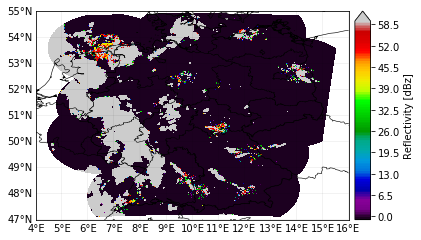

In [81]:
bmap.contourf(lon_wgs0,lat_wgs0,data[0],np.arange(-1,60,0.5),cmap='nipy_spectral',extend="max")

bmap.drawcoastlines(linewidth=0.6, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.6, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 1), linewidth=0.1, color='black', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 1), linewidth=0.1, color='black', labels=[True, False, False, True])
bmap.readshapefile('/Users/guidocioni/shapefiles/DEU_adm_shp/DEU_adm1','DEU_adm1',linewidth=0.3,color='black')
bmap.colorbar(location='right', label='Reflectivity [dBz]')

pl.title('RX Product single scan\n' + datestring)

# pl.grid(color='r')
pl.show()